# Making the trainig sample from CANDELS GOODS-S 

By Shooby, last edited August 29 2019



In [22]:
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import ndimage
from PIL import Image


%matplotlib inline

# High resolution GOODS-S galaxies to H<=26 and z<2

In [23]:
gs = pyfits.getdata('../../WFIRST_WPS/CANDELS_fits/gds.fits')
# real sample!: sel1 = (gs['zbest']>0.1)&(gs['zbest']<2.0)&(gs['CLASS_STAR']<0.9)&(gs['Hmag']<26.)&(gs['ISOAREA_IMAGE_F160W']>=5)&(gs['B_IMAGE_1']/gs['A_IMAGE_1']>0.7)
sel1 = (gs['zbest']>0.1)&(gs['zbest']<0.7)&(gs['CLASS_STAR']<0.8)&(gs['Hmag']<25.5)&(gs['ISOAREA_IMAGE_F160W']>=300)&(gs['B_IMAGE_1']/gs['A_IMAGE_1']>0.5)
sel2 = (gs['zbest']>0.1)&(gs['zbest']<1.0)&(gs['CLASS_STAR']<0.9)&(gs['Hmag']<25.5)&(gs['ISOAREA_IMAGE_F160W']>=300)&(gs['B_IMAGE_1']/gs['A_IMAGE_1']<0.5)

print (len(gs[sel1]),len(gs[sel2]))



500 137


In [24]:
##### percentile normalization function borrowed from Miladious! (didn't help)#####

def percentile_normalization(data, percentile_low = 1.5, percentile_high = 1.5, p_low_feed = None, p_high_feed = None, scale_coef = 1):
    
    p_low  = np.percentile(data, percentile_low)
    p_high = np.percentile(data, 100 - percentile_high)
    
    # Artificially set p_low and p_high
    if p_low_feed:
        p_low = p_low_feed
        
    if p_high_feed:
        p_high = p_high_feed
    
    # Bound values between q_min and q_max
    normalized = np.clip(data, p_low, p_high)
    # Shift the zero to prevent negative vlaues
    normalized = normalized - np.min(normalized)
    # Normalize so the max is 1
    normalized /= np.max(normalized)
    # Scale
    normalized *= scale_coef
    
    return normalized
#####################################################################################
def radec2xy(ra,dec,wc):
    coords = SkyCoord(ra,dec, unit='deg')
    a=wcs.utils.skycoord_to_pixel(coords, wc, origin=0,mode=u'wcs')
    return a[0],a[1]
    
def cut(ra,dec,andaze,filename):
    '''gets coordinates of the galaxy and the filter to return a cutout
    (also called a postage stamp) of the galaxy with given size'''
    hdr = pyfits.getheader(filename)
    w = wcs.WCS(hdr)
    x,y=radec2xy(ra,dec,w)
    x,y=np.int(x),np.int(y)
    im=pyfits.getdata(filename)[y-andaze:y+andaze,x-andaze:x+andaze]
    return im

def segment(a1,above_mean=1.1,add_image_back=0.3,random_noise=0.2):
    '''Returns segmentation of an image by some filtering of lower level 
    noises, to restrict the fitting to the galaxy itself and mask the 
    surroundings'''
    im2=ndimage.gaussian_filter(a1, 2)
    mask = (im2 > above_mean*im2.mean()).astype(np.float)
    mask += add_image_back * im2
    img = mask + random_noise*np.random.randn(*mask.shape)
    hist, bin_edges = np.histogram(img, bins=60)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    binary_im = img > random_noise
    open_img = ndimage.binary_opening(binary_im)
    close_img = ndimage.binary_closing(open_img)
    return close_img

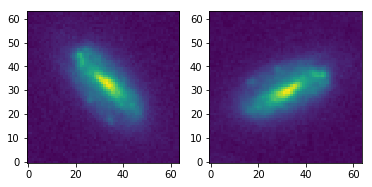

In [25]:
boz=100


ra1,dec1=gs['RA_1'][sel1],gs['DEC_1'][sel1]
data = cut(ra1[boz],dec1[boz],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f606w_060mas_v1.5_drz.fits')
#da = percentile_normalization(data)
da = np.arcsinh(data)
#da[np.isnan(da)]=0
#da[da<0]=0
rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
plt.subplot(1,2,1)
plt.imshow(rescaled,origin='lower')
plt.subplot(1,2,2)
import scipy
s = ndimage.rotate(rescaled,np.random.uniform(0,180),mode='mirror',reshape=False)
plt.imshow(s,origin='lower')

In [26]:
ra1,dec1=gs['RA_1'][sel1],gs['DEC_1'][sel1]
ra2,dec2=gs['RA_1'][sel2],gs['DEC_1'][sel2]

im = np.zeros([64,64])
for boz in range(3000):
    n = np.int(np.random.uniform(0,len(ra1)-1))
    data = cut(ra1[n],dec1[n],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f606w_060mas_v1.5_drz.fits')
    if data[0,0]!=0 :
        da = percentile_normalization(data)
        rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        angle = np.random.uniform(0,180)
        s = ndimage.rotate(rescaled,angle,mode='nearest',reshape=False)
        im = Image.fromarray(s)
        im.save('images/training_images/1/'+str(boz)+'.jpg')
    
    n = np.int(np.random.uniform(0,len(ra1)-1))
    data = cut(ra1[n],dec1[n],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f606w_060mas_v1.5_drz.fits')
    if data[0,0]!=0 :
        da = percentile_normalization(data)
        rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        angle = np.random.uniform(0,180)
        s = ndimage.rotate(rescaled,angle,mode='nearest',reshape=False)
        im = Image.fromarray(s)
        im.save('images/training_images/2/'+str(boz)+'.jpg')
    

    

In [27]:
ra1,dec1=gs['RA_1'][sel1],gs['DEC_1'][sel1]
ra2,dec2=gs['RA_1'][sel2],gs['DEC_1'][sel2]

im = np.zeros([64,64])
for boz in range(1000):
    n = np.int(np.random.uniform(0,len(ra1)-1))
    data = cut(ra1[n],dec1[n],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f606w_060mas_v1.5_drz.fits')
    if data[0,0]!=0 :
        da = percentile_normalization(data)
        rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        angle = np.random.uniform(0,180)
        s = ndimage.rotate(rescaled,angle,mode='nearest',reshape=False)
        im = Image.fromarray(s)
        im.save('images/test_images/1/'+str(boz)+'.jpg')
    
    n = np.int(np.random.uniform(0,len(ra1)-1))
    data = cut(ra1[n],dec1[n],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f606w_060mas_v1.5_drz.fits')
    if data[0,0]!=0 :
        da = percentile_normalization(data)
        rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        angle = np.random.uniform(0,180)
        s = ndimage.rotate(rescaled,angle,mode='nearest',reshape=False)
        im = Image.fromarray(s)
        im.save('images/test_images/2/'+str(boz)+'.jpg')
    

    

In [208]:
im = np.zeros([64,64])
for boz in range(5000,len(ra1)):
    data = cut(ra1[boz],dec1[boz],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f606w_060mas_v1.5_drz.fits')
    if data[0,0]!=0 :
        da = np.log10(data+1.0)
        da[np.isnan(da)]=0
        da[da<0]=0
        rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        im = Image.fromarray(rescaled)
        im.save('images/test_images/1/'+str(boz)+'.jpg')
    
        data = cut(ra1[boz],dec1[boz],32,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')
        da = np.log10(data+1.0)
        da[np.isnan(da)]=0
        da[da<0]=0
        rescaled = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        im = Image.fromarray(rescaled)
        im.save('images/test_images/2/'+str(boz)+'.jpg')
     

# Low resolution sample 
I do this in the GAN now <br>

    a) pixel-scale from 0.06"/pix to 0.18"/pix
    b) psf from ~0.18"? to 0.6"
    c) noise 